<ipython-input-2-3a603153d794>:46: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  (markers, stemlines, baseline) = ax.stem(cTime, cData,bottom=-0.4,label='Data',basefmt=" ")
/home/zjabbar/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-2-3a603153d794>:66: RuntimeWarning: overflow encountered in double_scalars
  Equation1=Variables[0]*(Alpha-Beta*Variables[1])
<ipython-input-2-3a603153d794>:67: RuntimeWarning: overflow encountered in double_scalars
  Equation2=-Variables[1]*(Gamma-Delta*Variables[0])
<ipython-input-2-3a603153d794>:46:

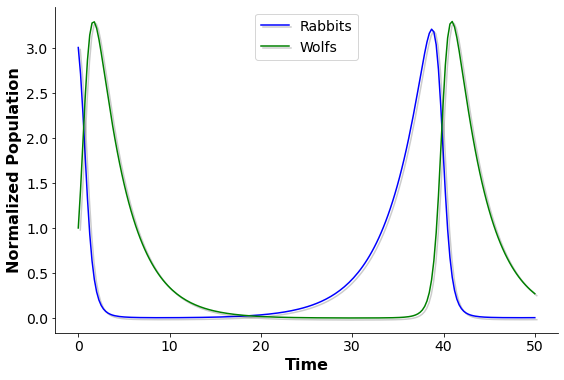

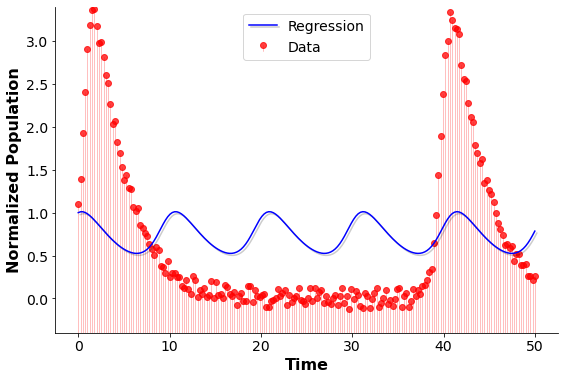

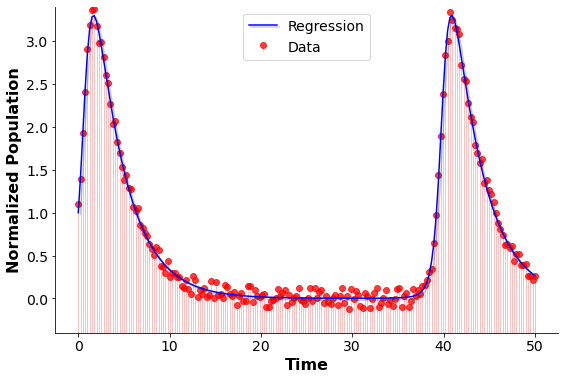

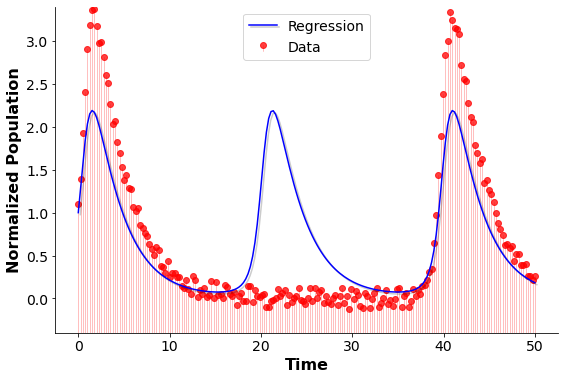

In [2]:
# -*- coding: utf-8 -*-
"""

@author: TavoGLC
From:

-Parameter estimation of differential equation models-

"""
###############################################################################
#                          Libraries to use  
###############################################################################

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import curve_fit

###############################################################################
#                    General plot functions 
###############################################################################

#Elimates the left and top lines and ticks in a matplotlib plot 
def PlotStyle(Axes,Title):
    
    Axes.spines['top'].set_visible(False)
    Axes.spines['right'].set_visible(False)
    Axes.spines['bottom'].set_visible(True)
    Axes.spines['left'].set_visible(True)
    Axes.xaxis.set_tick_params(labelsize=14)
    Axes.yaxis.set_tick_params(labelsize=14)
    Axes.set_title(Title)

#Lollipop plot based on the python graph gallery implementation 
def LollipopPlot(Fig,Time,Data,Regression):
    
    cTime=Time
    cData=Data
    cRegression=Regression
    
    ax=Fig.gca()

    (markers, stemlines, baseline) = ax.stem(cTime, cData,bottom=-0.4,label='Data',basefmt=" ")
    plt.setp(stemlines, linestyle="-", color="red", linewidth=0.5,alpha=0.5 )
    plt.setp(markers, color="red",alpha=0.75 )

    ax.plot(cTime,cRegression,'b-',label='Regression',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
  
    ax.set_ylabel('Normalized Population',fontsize=16,fontweight='bold')
    ax.set_xlabel('Time',fontsize=16,fontweight='bold')
    ax.legend(loc=0,fontsize=14)
    ax.set_ylim(-0.4,3.4)
    PlotStyle(ax,'')

###############################################################################
#                     ODE system Model solving  
###############################################################################

#Lodka-Volterra non linear model
def MakeModel(Alpha,Beta,Gamma,Delta,Variables):
    
    Equation1=Variables[0]*(Alpha-Beta*Variables[1])
    Equation2=-Variables[1]*(Gamma-Delta*Variables[0])
    
    return [Equation1,Equation2]

#Integration time
SolverTime=np.linspace(0,50,num=200)

#Parameters of the model 
alpha=0.25
beta=0.55
gamma=0.3
delta=0.6

#Initial conditions 
Int=np.array([3,1])  

#Model Solution 
def ODEModel(InitialConditions,t):

    return MakeModel(alpha,beta,gamma,delta,InitialConditions)

Solution=odeint(ODEModel,Int,SolverTime)

###############################################################################
#                           Visualization 
###############################################################################

plt.figure(1,figsize=(9,6))

plt.plot(SolverTime,Solution[:,0],'b-',label='Rabbits',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])
plt.plot(SolverTime,Solution[:,1],'g-',label='Wolfs',path_effects=[path_effects.SimpleLineShadow(alpha=0.2,rho=0.2),
                       path_effects.Normal()])

plt.xlabel('Time',fontsize=16,fontweight='bold')
plt.ylabel('Normalized Population',fontsize=16,fontweight='bold')
plt.legend(loc=0,fontsize=14)

ax=plt.gca()
PlotStyle(ax,'')

###############################################################################
#                            Data generation  
###############################################################################
def MakeNoisyData(Data,Noise):
    
    return [val+cal for val,cal in zip(Data,Noise)]

WhiteNoise=[np.random.uniform(low=-1,high=1)/8 for val in Solution[:,1]]
WhiteSignal=MakeNoisyData(Solution[:,1],WhiteNoise)

###############################################################################
#                    ODE system model fitting  
###############################################################################

def ModelSolver(t,Alpha,Beta,Gamma,Delta,InitialConditions):
    
    cAlpha=Alpha
    cBeta=Beta
    cGamma=Gamma
    cDelta=Delta
    
    cInit=InitialConditions
    
    def LocalModel(cInit,t):
        
        return MakeModel(cAlpha,cBeta,cGamma,cDelta,cInit)
    
    Solution=odeint(LocalModel,cInit,t)
    
    return Solution[:,1]

def ModelFit(t,Alpha,Beta,Gamma,Delta):
    
    return ModelSolver(t,Alpha,Beta,Gamma,Delta,Int)
    
ModelParams01=curve_fit(ModelFit,SolverTime,WhiteSignal)
FitSolution=ModelSolver(SolverTime,ModelParams01[0][0],ModelParams01[0][1],ModelParams01[0][2],ModelParams01[0][3],Int)

###############################################################################
#                    Standard parameter estimation  
###############################################################################

fig=plt.figure(2,figsize=(9,6))

LollipopPlot(fig,SolverTime,WhiteSignal,FitSolution)

###############################################################################
#                    Performance measurement
###############################################################################

#Measures the squared error between the data and the fit given an initial parameter guess
def SquaredError(InitialParameterGuess):
    
    try:
        #Some guesses will result in an error or an invalid integration 
        #this ensures that the error is estimated only for valid solutions 
        cModelParams=curve_fit(ModelFit,SolverTime,WhiteSignal,p0=InitialParameterGuess)
        cSolution=ModelSolver(SolverTime,cModelParams[0][0],cModelParams[0][1],cModelParams[0][2],cModelParams[0][3],Int)
    
        error=[(val-sal)**2 for val,sal in zip(cSolution,WhiteSignal)]
        
    except RuntimeError:
        
        #Based on the scale of the data the following list of values will be large enough to be rejected as a solution 
        error=[10,10]
    
    return sum(error)

###############################################################################
#                    Random Search of initial values  
###############################################################################

#Random selection of the initial guess values 
def RandomSearch(Iterations):
    
    nIt=Iterations 
    GuessContainer=[]
    ErrorContainer=[]
    
    for k in range(nIt):
        
        lGuess=[np.random.uniform(low=0,high=1) for val in range(4)]
        lerror=SquaredError(lGuess)
        
        GuessContainer.append(lGuess) #Contains the list of random initial values 
        ErrorContainer.append(lerror) #List of the errors 
    
    minError=np.min(ErrorContainer) #Min error value 
    minLocation=[j for j in range(nIt) if ErrorContainer[j]==minError] #Returns the location of the min value in the list
    
    bestGuess=GuessContainer[minLocation[0]] #Best initial value guess 
    
    return ErrorContainer,bestGuess
    
    
errs,bG=RandomSearch(10)    

###############################################################################
#                   Initial values Random Search Fitting 
###############################################################################

ModelParams02=curve_fit(ModelFit,SolverTime,WhiteSignal,p0=bG)
FitSolution2=ModelSolver(SolverTime,ModelParams02[0][0],ModelParams02[0][1],ModelParams02[0][2],ModelParams02[0][3],Int)

###############################################################################
#                              Visualization  
###############################################################################

fig=plt.figure(3,figsize=(9,6))

LollipopPlot(fig,SolverTime,WhiteSignal,FitSolution2)

###############################################################################
#                    Initial values Nelder-Mean Fitting
###############################################################################

#Vector of random initial values 
g0=[np.random.uniform(low=0,high=1) for val in range(4)] 

#Minimization of the squared error by Nelder-Mead 
res = minimize(SquaredError, g0, method='nelder-mead',options={'xtol': 1e-3, 'maxiter':100,'disp': False})

ModelParams03=curve_fit(ModelFit,SolverTime,WhiteSignal,p0=res.x)
FitSolution3=ModelSolver(SolverTime,ModelParams03[0][0],ModelParams03[0][1],ModelParams03[0][2],ModelParams03[0][3],Int)

###############################################################################
#                              Visualization 
###############################################################################

fig=plt.figure(4,figsize=(9,6))

LollipopPlot(fig,SolverTime,WhiteSignal,FitSolution3)